## Logistic Regression Problem
Mathematical formulation:
$$ 
f(x) = \frac{1}{2 n} \sum_{i=1}^n \log (1 + exp(-y_i a_i^T x)) + \frac{\lambda}{2} \|x\|^2_2
$$ 

In [53]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import sys
from sklearn.datasets import load_svmlight_file
from tqdm import tqdm

In [54]:
def f_logistic(A, y, x, lambd):
    n = A.shape[0]
    f = np.sum(np.log(1+np.exp(-np.dot(A, x) * y)))/(2*n) + (lambd/2)*np.sum(x**2)
    return f

$$
f_i(x) = \frac{1}{2} \log(1+exp(-y_i a^T_i x)) + \frac{\lambda}{2} \|x\|^2
$$
$$
\nabla f_i(x) = \frac{1}{2} \frac{-y_i}{exp(y_i a_i^T x) + 1} a_i + \lambda x
$$

## Logistic Regression Problem
Mathematical formulation:
$$ 
f(x) = \frac{1}{2 n} \sum_{i=1}^n \log (1 + exp(-y_i a_i^T x)) + \frac{\lambda}{2} \|x\|^2_2
$$ 

In [55]:
def grad_full(A, y, x, lambd):
    n = A.shape[0]
    num = -y
    den = (1 + np.exp(np.dot(A, x) * y))
    c = num/den
    c2 = np.dot(c.T,A)
    final_grad = (c2)/(2*n) + lambd * x
    return final_grad

In [56]:
def grad_f_logistic_i(A, y, x, lambd, random_ind, batch_size=1):
    n = A.shape[0]
    num = -y[random_ind]

    den = (1 + np.exp(np.dot(A[random_ind], x) * y[random_ind]))
    c = num/den
    c2 = np.dot(c.T,A[random_ind])
    final_grad = (c2)/(2*batch_size) + lambd * x
    return final_grad

In [57]:
# def grad_f_logistic_i1(A, y, x, lambd, random_ind, batch_size=1):
#     n = A.shape[0]
#     l = len(random_ind)
#     grad = 0
#     for i in range(l):
#         grad += -y[random_ind[i]]/(1+np.exp(y[random_ind[i]]*np.dot(A[random_ind[i]], x)))/2*A[random_ind[i]] + lambd*x
#     grad = grad/l
#     return grad

In [58]:
# n = 5
# d = 3
# A = np.random.rand(n, d)
# y = np.random.rand(n)
# x = np.random.rand(d)
# lambd = 1/n

# random_ind = np.arange(n)
# print(grad_full(A, y, x, lambd))
# print(grad_f_logistic_i(A, y, x, lambd, random_ind, 1))
# print(grad_f_logistic_i1(A, y, x, lambd, random_ind, 1))

In [59]:
def construct_v_independent_sampling(probab):
    n = len(probab)
    v = []
    for i in range(0, n):
        rand = np.random.rand();
        if rand <= probab[i]:
            v.append(i)
    return v

def construct_proper_sampling(n_batch, probab):
    random_ind = np.random.choice(n_batch, p=probab)
    return random_ind


def construct_tau_nice(n, tau):
    random_sample = np.random.choice(np.arange(n), tau, replace=False)
    return random_sample

## Calculating constants

$$
L_i = \frac{1}{8} \| \mathbf{A}(i,:) \|_2^2 + \lambda \ \ \forall i \\
\mu =  \lambda
$$

In [60]:
def calculate_mu_and_L (A, lambd):
    n = A.shape[0]
    mu =  lambd
    L = la.norm(A, axis=1, ord=2)**2/8 + lambd

    return mu, L

In [61]:
def calculate_M(A, lambd):
    n = A.shape[0]
    M = la.norm(A, axis=1, ord=2)**2/8 + lambd
    return M

In [62]:
def calculate_h (A, y, x_star, lambd):
    n = A.shape[0]
    h = [la.norm(grad_f_logistic_i(A, y, x_star, lambd, i))**2 for i in range(n)]

    return h

In [63]:
def calculate_sigma2_proper (probab, h):
    n = len(probab)
    sig = 0
    for i in range(n):
        sig += (1 / probab[i]) * h[i]
    sig = sig / n**2
    
    return sig

def calculate_L_cal_proper (probab, M):
    n = len(probab)
    L = max([M[i]/probab[i] for i in range(n)])
    L = L/n
    
    return L

In [64]:
def calculate_sigma2_indepedent (probab, h):
    n = len(probab)
    sig = 0

    for i in range(n):
        sig += (1 / probab[i] - 1) * h[i]
    sig = sig / n**2
    
    return sig

def calculate_L_cal_indepedent (probab, M):
    L = 0
    n = len(probab)
    
    for i in range(n):
        L += M[i]/n
    
    second_term = max([(1 / probab[i] - 1) * M[i]/n for i in range(n)])
    L += second_term
    
    return L

In [65]:
def calculate_sigma2_taunice (h, tau):
    n = len(h)
    sig = 0

    for i in range(n):
        sig += h[i]
    sig = sig/(n*tau)*(n-tau)/(n-1)
    
    return sig

def calculate_L_cal_taunice (M, tau, n):
    L = 0

    for i in range(n):
        L += M[i]/n
        
    L = L/tau*(tau-1)/(n-1)
    
    second_term = max([M[i] for i in range(n)])
    second_term = second_term/tau*(1-(tau-1)/(n-1))
    L += second_term
    
    return L

In [66]:
def calculate_prob_L(M, n, tau):
    pl = np.zeros(n)
    s = sum([M[i] for i in range(n)])
    over = set()
    below = set(range(n))

    for i in range(n):
        pl[i] = M[i] / s * tau
        if pl[i] == 1.0:
            below.discard(i)
        if pl[i] > 1:
            over.add(i)
            below.discard(i)
            
    while len(over) > 0:
        ind = over.pop()
        rem = pl[ind] - 1
        length_of_rem = len(below)
        pl[ind] = 1
        to_remove = set()
        
        for below_ind in below:
            pl[below_ind] += rem / length_of_rem
            if (pl[below_ind] > 1.0000000001):
                over.add(below_ind)
                to_remove.add(below_ind)
        
        for remove_ind in to_remove:
            below.discard(remove_ind)
            
    return pl

In [67]:
def calculate_prob_sigma(h, n, tau):
    ps = np.zeros(n)
    s = sum([abs(np.sqrt(h[i])) for i in range(n)])
    over = set()
    below = set(range(n))
    
    for i in range(n):
        ps[i] = np.sqrt(h[i]) / s * tau
        if ps[i] == 1.0:
            below.discard(i)
        if ps[i] > 1:
            over.add(i)
            below.discard(i)
            
    while len(over) > 0:
        ind = over.pop()
        rem = ps[ind] - 1
        length_of_rem = len(below)
        ps[ind] = 1
        to_remove = set()
        
        for below_ind in below:
            ps[below_ind]+= rem / length_of_rem
            if ps[below_ind] > 1.0000000001:
                over.add(below_ind)
                to_remove.add(below_ind)
        
        for remove_ind in to_remove:
            below.discard(remove_ind)
            
    return ps

In [68]:
def calculate_optimal_prob_independent(M, h, n, tau, epsilon, mu):
    a = 2 * (sum([np.sqrt(h[i]) for i in range(n)])/n)**2 / (epsilon * mu * sum([M[i] for i in range(n)])/n)
#     print(a)
    alpha = (tau - a - 1 + np.sqrt(4 * tau + (tau - a - 1)**2)) / (2 * tau)
    
    pl = calculate_prob_L(M, n, int(alpha*tau))
    ps = calculate_prob_sigma(h, n, int((1-alpha)*tau))
    
#     print(alpha)
    p_opt =  pl +  ps
    
    return p_opt

In [69]:
def calculate_optimal_prob_proper(M, h, n, epsilon, mu):
    pl = calculate_prob_L(M, n, 1)
    ps = calculate_prob_sigma(h, n, 1)
    L_opt = sum([M[i] for i in range(n)])/n
    sig2_opt = (sum([abs(np.sqrt(h[i])) for i in range(n)])/n)**2
    print(sig2_opt)
    alpha = epsilon*mu*L_opt/(2*sig2_opt+epsilon*mu*L_opt)
    print(alpha)
    p_opt = alpha * pl + (1 - alpha) * ps
    
    return p_opt

In [70]:
def calculate_stepsize(L_cal, epsilon, mu, sigma2):
    gamma = min(1 / (2 * L_cal), epsilon * mu / (4 * sigma2))

    return gamma

In [71]:
def calculate_expected_number_of_epochs(L_cal, epsilon, mu, sigma2, x0, x_star, n):
    k = max(2 * L_cal / mu, 4 * sigma2 / (epsilon * mu**2)) * np.log(2 * la.norm(x0 - x_star)**2 / epsilon)
    return k/n

In [72]:
def calculate_tau_star_independent(h, L, n, mu, epsilon):
    t = 0
    h_bar = sum(h)/n
    L_max = max(L)
    t = n*(2/(mu*epsilon)*h_bar - L_max)/(2/(mu*epsilon)*h_bar - L_max + sum(L))
    return t
    

In [73]:
def calculate_tau_star_taunice(h, L, n, mu, epsilon):
    t = 0
    h_bar = sum(h)/n
    L_max = max(L)
    L_bar = sum(L)/n
    
    t = n*(L_bar - L_max + 2/(mu*epsilon)*h_bar)/(n*L_bar - L_max + 2/(mu*epsilon)*h_bar)
    return t
    

In [74]:
def GD(A, y, x0, lambd, step_size, 
        epsilon=1e-10, max_epoch=200000):
    
   
    n = A.shape[0]
    d = A.shape[1]
    
    x = x0
    

    iter_num = 0
    
    n_batch = np.arange(n)
    
    full_grad_adel = grad_full(A, y, x, lambd)
    grad = la.norm(full_grad_adel)**2
    
    while grad > epsilon: 
        full_grad_adel = grad_full(A, y, x, lambd)
        x_new = x - step_size * full_grad_adel
        x = x_new
        iter_num += 1
        grad = la.norm(full_grad_adel)**2
        if (iter_num%20000==0):
            print(grad)
    
    print("Number of epochs:", iter_num)
    print("Grad error:", la.norm(grad_full(A, y, x, lambd))**2 )
    print()
    
    return x

In [75]:
def solution(A, y, lambd):
    n = A.shape[0]
    d = A.shape[1]
    L = la.norm(np.dot(A.T,A)/(8*n)) + lambd

    st_s = 1/(2*L)
    st_s = st_s 
    print(st_s)
    x0 = np.random.randn(d)
    x_opt = GD(A, y, x0, lambd, st_s, 1e-10)
    return x_opt

In [76]:
# def sgd(A, y, x0, x_star, lambd, probab, step_size, 
#         epsilon=1e-6, max_epoch=100, seed=42, kind="proper", tau = 1):
    
#     np.random.seed(seed)
    
#     n = A.shape[0]
#     d = A.shape[1]
    
#     x = x0
    
#     epoch_num = 0
#     iter_num = 0
    
#     n_batch = np.arange(n)
    
#     error = [la.norm(x - x_star)**2]
#     f_values = [f_logistic(A, y, x, lambd)]
    
#     while epoch_num < max_epoch and error[-1] > epsilon: 
        
#         if (kind == "proper"):
#             v = construct_proper_sampling(n_batch, probab)
#             x = x - step_size * grad_f_logistic_i(A, y, x, lambd, v)
#             iter_num += 1
#         elif (kind == "taunice"):
#             v = construct_tau_nice(n, tau)
#             x_new = x - step_size * grad_f_logistic_i(A, y, x, lambd, v, len(v))
#             x = x_new
#             iter_num += len(v)
#         else:
#             v = construct_v_independent_sampling(probab)
#             if len(v) == 0:
#                 x = x
#             else:
#                 x = x - step_size * grad_f_logistic_i(A, y, x, lambd, v, len(v))
#             iter_num += len(v)
        

#         if iter_num >= n :
#             f = open("log.txt", "w+")
#             f.write(str(epoch_num) + " error: " + str(error[-1]))
#             f.close()
#             epoch_num += 1
#             iter_num = 0
#             f_values.append(f_logistic(A, y, x, lambd))
#             error.append(la.norm(x - x_star)**2)
    
    
#     print("Number of epochs:", epoch_num)
#     print("Error:", la.norm(x - x_star)**2)
#     print()
    
#     return x, f_values, error

In [77]:
def sgd(A, y, x_0, x_star, lambd, 
        step_size=1e-2, batch_size=1, 
        epsilon=1e-3, max_epoch=100, seed=0):
    
    np.random.seed(seed)
    n = A.shape[0]
    x = x_0
    
    epoch_num = 0
    iter_num = 0
    
    error = [la.norm(x - x_star)**2]
    f_values = [f_logistic(A, y, x, lambd)]
    
    #     while epoch_num < max_epoch and error[-1] > epsilon: 
    #         iter_num += 1
    for iter_num in tqdm(range(max_epoch * n)):
        if error[-1] < epsilon:
            break
        random_ind = np.random.randint(A.shape[0], size=batch_size)
        x = x - step_size * grad_f_logistic_i(A, y, x, lambd, random_ind)
        
        if iter_num % A.shape[0] == 0:
            epoch_num += 1
            
            f_values.append(f_logistic(A, y, x, lambd))
            error.append(la.norm(x - x_star)**2)
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error

In [78]:
def adaptive_step_size(L_cal, mu, k):
    cal_K = np.ceil(L_cal / mu)
    
    if k <= 4 * cal_K:
        return 1 / (2 * L_cal)
    else:
        return (2 * k + 1) / (k + 1)**2 / mu

In [79]:
def sgd_adaptive(A, y, x_0, x_star, lambd, L_cal, mu,
                 step_size=1e-2, batch_size=1, 
                 epsilon=1e-3, max_epoch=100, seed=0):
    
    np.random.seed(seed)
    n = A.shape[0]
    x = x_0
    
    epoch_num = 0
    iter_num = 0
    
    error = [la.norm(x - x_star)**2]
    f_values = [f_logistic(A, y, x, lambd)]
    
    #     while epoch_num < max_epoch and error[-1] > epsilon: 
    #         iter_num += 1
    for iter_num in tqdm(range(max_epoch * n)):
        if error[-1] < epsilon:
            break        
        step_size = adaptive_step_size(L_cal, mu, k=iter_num)
        random_ind = np.random.randint(A.shape[0], size=batch_size)
        x = x - step_size * grad_f_logistic_i(A, y, x, lambd, random_ind)
        
        
        
        if iter_num % A.shape[0] == 0:
            epoch_num += 1
            f_values.append(f_logistic(A, y, x, lambd))
            error.append(la.norm(x - x_star)**2)    
    
    print("Number of epochs:", epoch_num)
    print("Error:", la.norm(x - x_star)**2)
    print()
    
    return x, f_values, error

In [80]:
def calculate_neighborhood_region(step_size, sigma_2, mu):
    return 2 * step_size * sigma_2 / mu

### Synthetic Data

In [47]:
n = 2000
d = 100
lambd = 1/n

A = np.random.randn(n, d)
y = np.random.choice([-1, 1], size = n)

x_star = solution(A, y, lambd)


0.3910620184918801
Number of epochs: 396
Grad error: 8.963353128558713e-11



In [48]:
max_epoch = 200
epsilon = 1e-5
seed = 0

np.random.seed(seed)

# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

mu, L = calculate_mu_and_L(A, lambd)

M = calculate_M(A, lambd)
h = calculate_h(A, y, x_star, lambd)

sigma_2 = calculate_sigma2_proper(np.ones(n)/n, h)
L_cal = calculate_L_cal_proper(np.ones(n)/n, M)

step_size = 1 / (2 * L_cal)
print("Step size:", step_size)

# k_switch = int(4 * np.ceil(L_curly / mu) / n)
nbrhd_region_size = calculate_neighborhood_region(step_size, sigma_2, mu)
print("Neighborhood region size:", nbrhd_region_size)

x_0 = np.random.normal(size=len(x_star))

# Constant step-size
x_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, 
                                         max_epoch=max_epoch, epsilon=epsilon)

# Decreasing step-size
x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_cal, mu, 
                                                  max_epoch=max_epoch, epsilon=epsilon)

  1%|          | 4953/400000 [00:00<00:07, 49527.45it/s]

Step size: 0.026625711793054514
Neighborhood region size: 633.8407321214237


  1%|          | 4139/400000 [00:00<00:09, 41386.19it/s]

Number of epochs: 200
Error: 0.9989604420424163



100%|██████████| 400000/400000 [00:08<00:00, 44789.33it/s]

Number of epochs: 200
Error: 0.3026935383464171



In [49]:
k_switch = int(4 * np.ceil(L_cal / mu) / n)
k_switch

75

In [50]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 42#24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 42#36
plt.rcParams['axes.labelsize'] = 36#24

plt.rc('text', usetex=True)

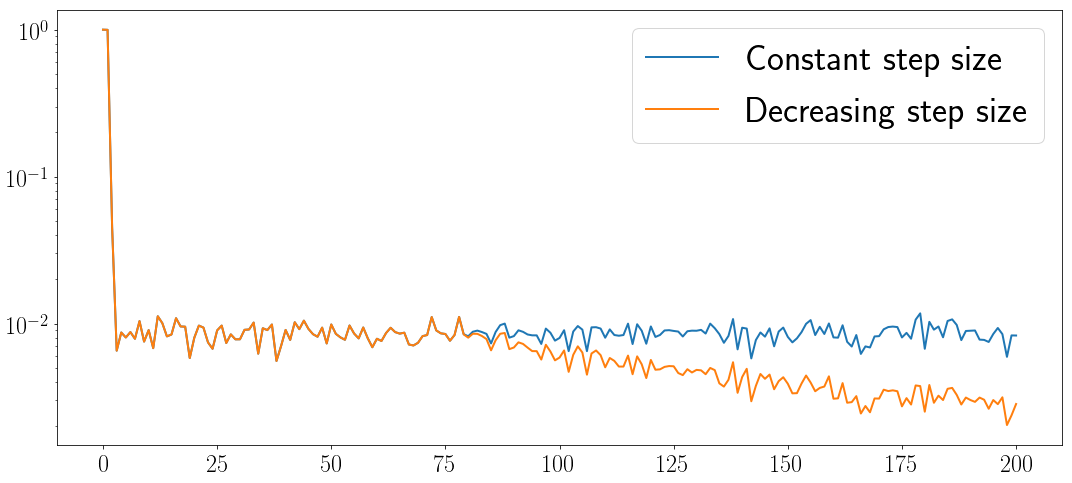

In [73]:
plt.figure(figsize=(18, 8))
plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size')
plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size')
plt.legend()
plt.show()

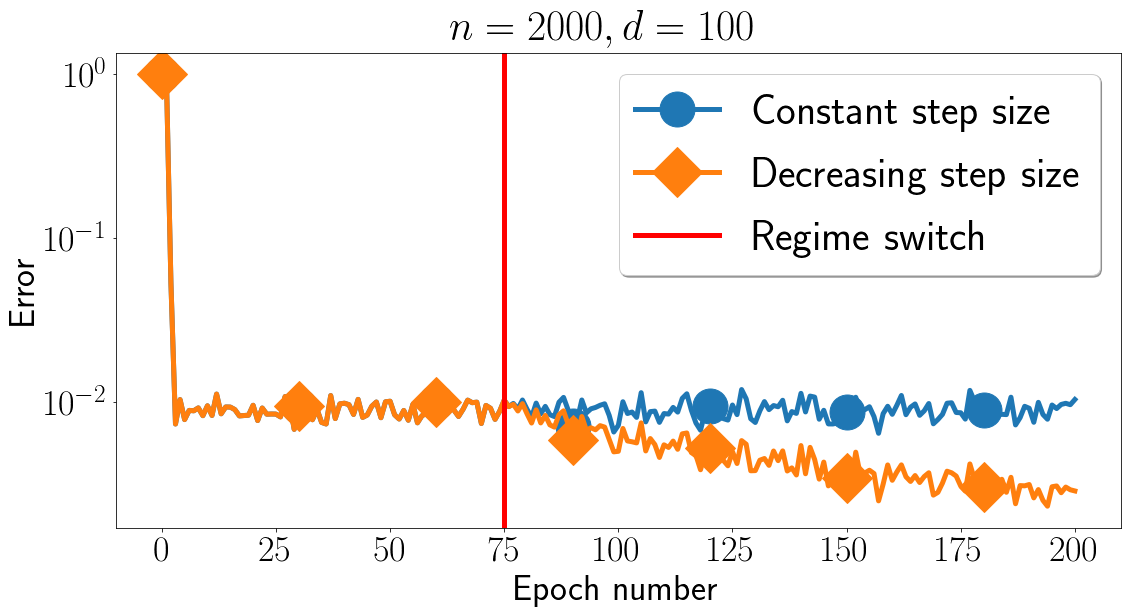

In [52]:
"""PLOTTING"""
fig = plt.figure(figsize=(18, 8))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=42)

# plt.subplot(1, 2, 1)

plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size', 
             marker='o', markersize=35, markevery=30, linewidth=5)
plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size', 
             marker='D', markersize=35, markevery=30, linewidth=5)
plt.axvline(k_switch, color='r', linewidth=5, label="Regime switch")
# plt.axhline(nbrhd_region_size / la.norm(x_0 - x_star)**2, 
#             color='g', linestyle='--', linewidth=5, label="Neighborhood region") # label=r"$\frac{2 \gamma \sigma^2}{\mu}$"
#     plt.axvline(k_switch, color='r')#, label=r"$4 \lceil \mathcal{K} \rlceil$")
#     trans = transforms.blended_transform_factory(plt.get_yticklabels()[0].get_transform(), plt.transData)
#     plt.text(k_switch, 0, "{:.0f}".format(k_switch), color="red", transform=trans)#, ha="right", va="center")
plt.xlabel("Epoch number")
plt.ylabel("Error") #  r"$\|x_k - x^*\|^2$

# plt.xlim((0, 150))
# plt.grid()
plt.minorticks_off()
# plt.title(r"$n = {}, d = {}$".format(n_1, d_1), y=1.01, fontsize=24)#, fontsize=36)
plt.legend(loc='best', shadow=True)

# plt.subplot(1, 2, 2)

# plt.semilogy(x_err_const_2, label='Constant step size')
# plt.semilogy(x_err_adapt_2, label='Decreasing step size')
# #     plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size')
# #     plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size')
# #     plt.axvline(k_switch, color='r', label="Regime switch")
# plt.axhline(nbrhd_region_size, color='r', linestyle='--', label="Neighborhood region") # label=r"$\frac{2 \gamma \sigma^2}{\mu}$"
# #     plt.fill_between()
# #     plt.axvline(k_switch, color='r')#, label=r"$4 \lceil \mathcal{K} \rlceil$")
# #     trans = transforms.blended_transform_factory(plt.get_yticklabels()[0].get_transform(), plt.transData)
# #     plt.text(k_switch, 0, "{:.0f}".format(k_switch), color="red", transform=trans)#, ha="right", va="center")
# plt.xlabel("Epoch number: $k$")
# plt.ylabel("Error: "r"$\|x_k - x^*\|^2$")
# plt.xlim((0, max_epoch_2))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), y=1.01, fontsize=24)#, fontsize=36)
# plt.grid()
# plt.minorticks_off()
# plt.legend(loc='best', shadow=True)

st.set_y(1.03)
fig.subplots_adjust(top=0.95)
# plt.tight_layout(w_pad=2)
plt.savefig('constant_vs_decreasing_ss_logistic_n2000_100_without.pdf', bbox_inches='tight')
plt.show()

In [81]:
from sklearn.datasets import load_svmlight_file

def get_data():
    data = load_svmlight_file("/home/sailana/Desktop/Real_dataset/a1a")
    return data[0], data[1]

A, y = get_data()

A = A.todense()
A = np.array(A)

n = A.shape[0]
d = A.shape[1]

# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

lambd = 1/n
x_star = solution(A, y, lambd)



0.6188359745930658
Number of epochs: 15526
Grad error: 9.985221139875898e-11



In [38]:
max_epoch = 200
epsilon = 1e-5
seed = 0

np.random.seed(seed)

# A = A / (la.norm(A, axis=1, ord=2)).reshape(A.shape[0], -1)

mu, L = calculate_mu_and_L(A, lambd)

M = calculate_M(A, lambd)
h = calculate_h(A, y, x_star, lambd)

sigma_2 = calculate_sigma2_proper(np.ones(n)/n, h)
L_cal = calculate_L_cal_proper(np.ones(n)/n, M)

step_size = 1 / (2 * L_cal)
print("Step size:", step_size)

# k_switch = int(4 * np.ceil(L_curly / mu) / n)
nbrhd_region_size = calculate_neighborhood_region(step_size, sigma_2, mu)
print("Neighborhood region size:", nbrhd_region_size)

x_0 = np.random.normal(size=len(x_star))

# Constant step-size
x_const, f_vals_const, x_err_const = sgd(A, y, x_0, x_star, lambd, step_size=step_size, 
                                         max_epoch=max_epoch, epsilon=epsilon)

# Decreasing step-size
x_adapt, f_vals_adapt, x_err_adapt = sgd_adaptive(A, y, x_0, x_star, lambd, L_cal, mu, 
                                                  max_epoch=max_epoch, epsilon=epsilon)

  1%|▏         | 4547/321000 [00:00<00:06, 45465.92it/s]

Step size: 0.28561259898567487
Neighborhood region size: 322.2063449542776


  1%|▏         | 4418/321000 [00:00<00:07, 44172.99it/s]

Number of epochs: 200
Error: 4.280680889730463



100%|██████████| 321000/321000 [00:06<00:00, 47850.31it/s]

Number of epochs: 200
Error: 0.11314232222542159



In [40]:
k_switch = int(4 * np.ceil(L_cal / mu) / n)
k_switch

7

In [43]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 42#24
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 42#36
plt.rcParams['axes.labelsize'] = 36#24

plt.rc('text', usetex=True)

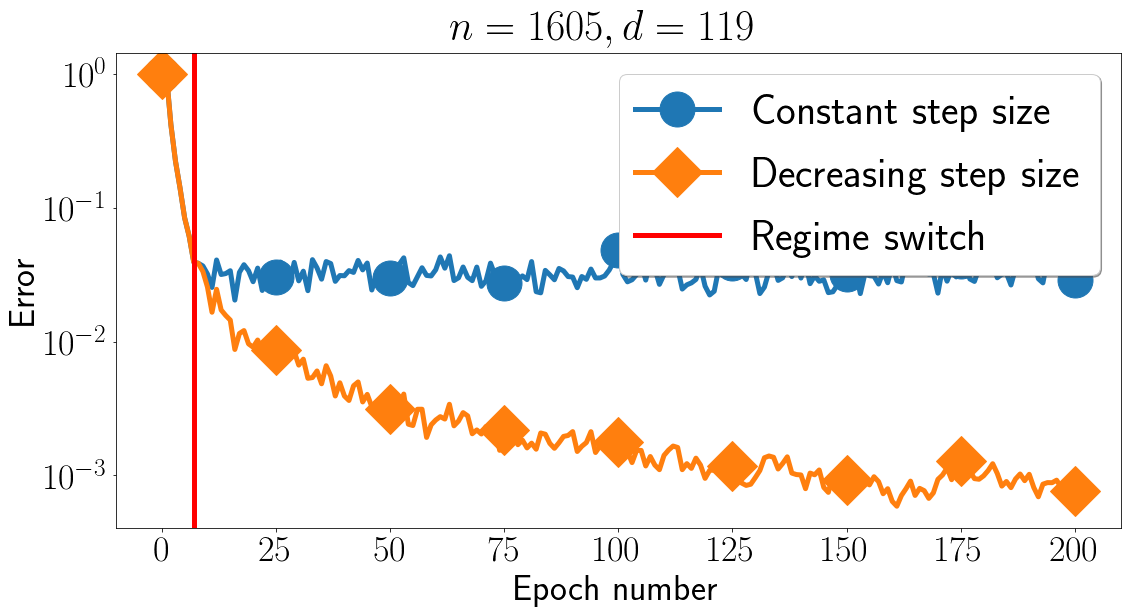

In [44]:
"""PLOTTING"""
fig = plt.figure(figsize=(18, 8))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), fontsize=42)
st = fig.suptitle(r"$n = {}, d = {}$".format(n, d), fontsize=42)

# plt.subplot(1, 2, 1)

plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size', 
             marker='o', markersize=35, markevery=25, linewidth=5)
plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size', 
             marker='D', markersize=35, markevery=25, linewidth=5)
plt.axvline(k_switch, color='r', linewidth=5, label="Regime switch")
# plt.axhline(nbrhd_region_size / la.norm(x_0 - x_star)**2, 
#             color='g', linestyle='--', linewidth=5, label="Neighborhood region") # label=r"$\frac{2 \gamma \sigma^2}{\mu}$"
#     plt.axvline(k_switch, color='r')#, label=r"$4 \lceil \mathcal{K} \rlceil$")
#     trans = transforms.blended_transform_factory(plt.get_yticklabels()[0].get_transform(), plt.transData)
#     plt.text(k_switch, 0, "{:.0f}".format(k_switch), color="red", transform=trans)#, ha="right", va="center")
plt.xlabel("Epoch number")
plt.ylabel("Error") #  r"$\|x_k - x^*\|^2$

# plt.xlim((0, 150))
# plt.grid()
plt.minorticks_off()
# plt.title(r"$n = {}, d = {}$".format(n_1, d_1), y=1.01, fontsize=24)#, fontsize=36)
plt.legend(loc='upper right', shadow=True)

# plt.subplot(1, 2, 2)

# plt.semilogy(x_err_const_2, label='Constant step size')
# plt.semilogy(x_err_adapt_2, label='Decreasing step size')
# #     plt.semilogy(x_err_const / la.norm(x_0 - x_star)**2, label='Constant step size')
# #     plt.semilogy(x_err_adapt / la.norm(x_0 - x_star)**2, label='Decreasing step size')
# #     plt.axvline(k_switch, color='r', label="Regime switch")
# plt.axhline(nbrhd_region_size, color='r', linestyle='--', label="Neighborhood region") # label=r"$\frac{2 \gamma \sigma^2}{\mu}$"
# #     plt.fill_between()
# #     plt.axvline(k_switch, color='r')#, label=r"$4 \lceil \mathcal{K} \rlceil$")
# #     trans = transforms.blended_transform_factory(plt.get_yticklabels()[0].get_transform(), plt.transData)
# #     plt.text(k_switch, 0, "{:.0f}".format(k_switch), color="red", transform=trans)#, ha="right", va="center")
# plt.xlabel("Epoch number: $k$")
# plt.ylabel("Error: "r"$\|x_k - x^*\|^2$")
# plt.xlim((0, max_epoch_2))
# plt.title(r"$n = {}, d = {}$".format(n_2, d_2), y=1.01, fontsize=24)#, fontsize=36)
# plt.grid()
# plt.minorticks_off()
# plt.legend(loc='best', shadow=True)

st.set_y(1.03)
fig.subplots_adjust(top=0.95)
# plt.tight_layout(w_pad=2)
plt.savefig('constant_vs_decreasing_ss_logistic_a1a.pdf', bbox_inches='tight')
plt.show()